In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from scipy.misc import imread, imsave
import cv2
import matplotlib.pyplot as plt
from scipy.misc import imread, imsave

# Any results you write to the current directory are saved as output.

## Read Data

In [3]:
path_data = './data/train.csv'
data = pd.read_csv(path_data)

In [4]:
data.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


#### Show Example

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


Text(0.5,1,'w_f48451c')

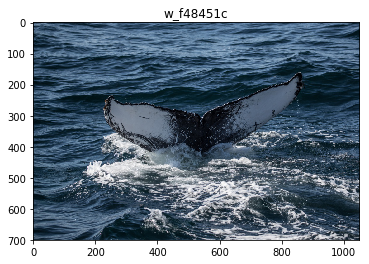

In [5]:
# Take example
data_example = data.loc[0].values

img_dir = data_example[0]
label = data_example[1]

# Read image
path_join = os.path.join('./data/train_images', img_dir)
image = imread(path_join)

# Plot image
imgplot = plt.imshow(image)
plt.title(label)

We can observe that there are some images with text. We have built a function to clean automatically the text, it works at 85/90 %, this is the first approach. I'm going to improve it. Below, an example:

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


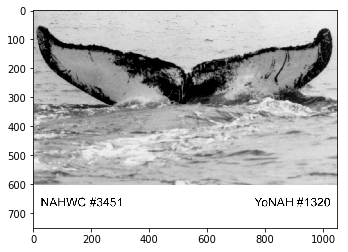

In [6]:
path_join = os.path.join('./data/train_images', '2b96cac5a.jpg')
image = imread(path_join)

backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
plt.imshow(backtorgb)

## Function to Clean Text Automatically

Take the images and convert it to gray scale and we measure the number of white pixels (between 245 - 255) in the bottom of the image. Then we convert the image to blur scale and calculate the lines, if the slope of the lines is between -0.06 and 0.06 we return the values. Finally, we delete that part of the images.

Basically:

* 1.- We convert the image to grayscale
* 2.- Take the 25% bottom part of the image 
* 3.- Count the number of white pixels (white pixels >= 250)
* 4.- If the number of white pixels is more than 90000 we apply this:
* 5.- Convert the image to blurscale
* 6.- Calculate the lines and slope
* 7.- If the slope is between -0.06 and 0.06 return this values
* 8.- If we have slope between -0.06 and 0.06 take the minimum line in y axis.
* 9.- Delete from that point to the end of the picture

In [7]:
def clean_image(image):

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    low_threshold = 20
    high_threshold = 50
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 3  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    y_1 = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope  = (y2 - y1) / (x2 - x1)
            if slope < 0.06 and slope > -0.06:
                region = gray.shape[0] - (gray.shape[0] * 0.30)
                if y1 > region:
                    y_1.append(y1)    
            else:
                continue
    return y_1

These are the lines to apply this function for every image, take time to preprocess all images and return 2 arrays (`images_preprocess` and `labels_preprocess`). 

In [8]:

data_images = data['Image'].values
data_labels = data['Id'].values

images_preprocess = []
labels_preprocess = []

##############################################################
# NOTE: DELETE data_images[:10] to preprocess all images. 
##############################################################
print('DELETE -> [:10] // in data_images[:10] to preprocess all images')

i = 0
for items in data_images[:10]:
    path_join = os.path.join('./data/train_images', items)
    image = cv2.imread(path_join)
    image_original = image

    if len(image.shape) < 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Crop the image and check if has white pixels
    bottom_percent = 0.25
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))
    img = image[bottom:image.shape[0], :]

    n_white_pix = np.sum(img >= 250)

    if n_white_pix >= 90000:
        y1 = clean_image(image)

        # Crop image
        if y1:
            min_y1 = min(y1)
            image_original = image_original[0:min_y1, 0:image_original.shape[1]]
            images_preprocess.append(image_original)
            labels_preprocess.append(data_labels[i])
    else:
        images_preprocess.append(image_original)
        labels_preprocess.append(data_labels[i])

    i += 1
    
images_preprocess = np.array(images_preprocess)
labels_preprocess = np.array(labels_preprocess)

DELETE -> [:10] // in data_images[:10] to preprocess all images


C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in int_scalars


In [9]:
print(images_preprocess.shape)
print(labels_preprocess.shape)

(10,)
(10,)


### Example with image

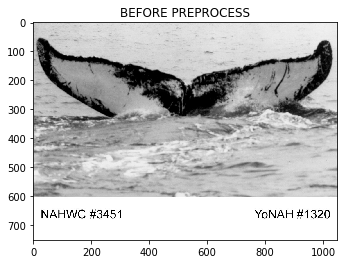

C:\Users\aleja\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in int_scalars


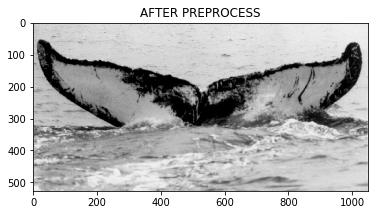

In [10]:
path_join = os.path.join('./data/train_images', '2b96cac5a.jpg')
# image = imread(path_join)
image = cv2.imread(path_join)
image_original = image
plt.imshow(image)
plt.title('BEFORE PREPROCESS')
plt.show()

if len(image.shape) < 3:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Crop the image and check if has white pixels
bottom_percent = 0.25
bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))
img = image[bottom:image.shape[0], :]

n_white_pix = np.sum(img >= 250)

if n_white_pix >= 90000:
    y1 = clean_image(image)

    # Crop image
    if y1:
        min_y1 = min(y1)
        image_original = image_original[0:min_y1, 0:image_original.shape[1]]
else:
    pass

plt.imshow(image_original)
plt.title('AFTER PREPROCESS')
plt.show()

Works in the most cases but in some images doesn't work correctly, I'm going to try to improve it. I hope this is helpful for you!!